In [1]:
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  #忽略烦人的警告
tf.logging.set_verbosity(tf.logging.ERROR)   #忽略烦人的警告
print(tf.__version__)
import numpy as np
from sklearn.decomposition import PCA

import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
import pickle   #对象存储用


from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
rfr = RandomForestClassifier(n_estimators=200, criterion='entropy')

dataroot_1 = "./UNSW-NB15 - CSV Files/a part of training and testing set/UNSW_NB15_training-set.csv"
dataroot_2 = "./UNSW-NB15 - CSV Files/a part of training and testing set/UNSW_NB15_testing-set.csv"

1.13.1


In [2]:
df_train_1 = pd.read_csv(dataroot_1,header=0,low_memory=False)  
df_train_2 = pd.read_csv(dataroot_2,header=0,low_memory=False)  
dataset = df_train_1.append([df_train_2])

In [3]:
print(dataset.shape)
print(dataset.columns)
print(dataset.values[0])
print(dataset.loc[:,'attack_cat'].value_counts())

(257673, 45)
Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')
[1 1.1e-05 'udp' '-' 'INT' 2 0 496 0 90909.0902 254 0 180363632.0 0.0 0 0
 0.011000000000000001 0.0 0.0 0.0 0 0 0 0 0.0 0.0 0.0 248 0 0 0 2 2 1 1 1
 2 0 0 0 1 2 0 'Normal' 0]
Normal            93000
Generic           58871
Exploits          44525
Fuzzers           24246
DoS               16353
Reconnaissance    13987
Analysis           2677
Backdoor           2329
Shellcode          1511
W

In [4]:
def filter_useless_feature(dataset):
    dataset = dataset.drop(['label'], axis=1)    #两个特征没用
    dataset = dataset.drop(['id'], axis=1)
    return dataset

def filter_labels(dataset):
    dataset['attack_cat'] = dataset['attack_cat'].apply(labels_map)
    return dataset

def labels_map(label):
    if(type(label) == int):      #已是数字，无需处理
        return label
    
    if label == 'Normal':
        return 0
    if label == 'Fuzzers':
        return 1
    if label == 'Analysis':
        return 2
    if label == 'Backdoor':
        return 3
    if label == 'DoS':
        return 4
    if label == 'Exploits':
        return 5
    if label == 'Generic':
        return 6
    if label == 'Reconnaissance':
        return 7
    if label == 'Shellcode':
        return 8
    if label == 'Worms':
        return 9
    return -1

def split_valid_from_train(train_dataset, valid_size):
    # Method 1
    train_dataset, valid_dataset, _, _ = train_test_split(train_dataset, train_dataset['attack_cat'], test_size=valid_size, random_state=None)
    # pandas中先重置index再打乱train. 否则只会调整各个行的顺序，而不会改变pandas的index
    # 重置
    train_dataset = train_dataset.reset_index(drop=True)
    # 打乱
    indexMask = np.arange(len(train_dataset))
    for i in range(10):
        np.random.shuffle(indexMask)
    train_dataset = train_dataset.iloc[indexMask]

    return train_dataset, valid_dataset

def labels_separate(dataset):
    y_ = dataset['attack_cat'].values
    temp = dataset
    temp.drop('attack_cat', axis=1, inplace=True)
    x_ = temp.values
    return x_, y_

def one_hot_process(dataset):
    # 独热编码 state
    state_dummies = pd.get_dummies(dataset['state'], prefix='state')
    dataset = pd.concat([dataset, state_dummies], axis=1)
    dataset = dataset.drop(['state'], axis=1)
    # 独热编码 proto
    proto_dummies = pd.get_dummies(dataset['proto'], prefix='proto')
    dataset = pd.concat([dataset, proto_dummies], axis=1)
    dataset = dataset.drop(['proto'], axis=1)
    # 独热编码 service     
    service_dummies = pd.get_dummies(dataset['service'], prefix='service')
    dataset = pd.concat([dataset, service_dummies], axis=1)
    dataset = dataset.drop(['service'], axis=1)
    return dataset
#归一化整个数据集，注意要存储归一化的参数x_avg,x_max,x_min以便后面真实环境预处理需要
def normalization(dataset):
    epsilon = 0.0001   #防止除数为0
    dataset = dataset.astype('float')
    target_features = ['dur','spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst'
    ]
    norm_params = pd.DataFrame(np.zeros([3, len(target_features)]), columns=target_features)  #存储归一化参数
    
    for feature in dataset.columns.values.tolist():    #对列（特征名）进行遍历
        if feature in target_features:
            x = dataset[feature]
            x_avg = dataset[feature].mean()
            x_max = np.max(dataset[feature])
            x_min = np.min(dataset[feature])

            norm_params[feature] = [x_avg, x_max, x_min]
            dataset[feature] = (x - x_min) / (x_max - x_min + epsilon)
    return dataset,norm_params
    
def combine_dataset(trainDF, testDF):
    all = pd.concat([trainDF, testDF], axis=0)
    return all, (trainDF.shape[0], testDF.shape[0])

def separate_dataset(comb, num_comb):  
    train_dataset_size , test_dataset_size = num_comb
    trainDF = comb.iloc[:train_dataset_size]
    testDF = comb.iloc[train_dataset_size: (train_dataset_size + test_dataset_size)]
    return trainDF, testDF

   
def data_process_full(trainDF, testDF):
    all, num_comb = combine_dataset(trainDF, testDF)
    all = one_hot_process(all)
    all,norm_params = normalization(all)
    trainDF,testDF = separate_dataset(all, num_comb)
    return trainDF,testDF,norm_params

In [5]:
dataset = filter_useless_feature(dataset)
dataset = filter_labels(dataset)

In [6]:
normal_df = dataset.loc[dataset['attack_cat'] == 0]
normal_df = normal_df.sample(n=90000,random_state=1, replace=False)
df_normal_train, df_normal_test = split_valid_from_train(normal_df, 0.2)

Fuzzers_df = dataset.loc[dataset['attack_cat'] == 1]
Fuzzers_df = Fuzzers_df.sample(n=24000,random_state=1, replace=False)
df_Fuzzers_train, df_Fuzzers_test = split_valid_from_train(Fuzzers_df, 0.2)

Analysis_df = dataset.loc[dataset['attack_cat'] == 2]
Analysis_df = Analysis_df.sample(n=2400,random_state=1, replace=False)
df_Analysis_train, df_Analysis_test = split_valid_from_train(Analysis_df, 0.2)

Backdoor_df = dataset.loc[dataset['attack_cat'] == 3]
Backdoor_df = Backdoor_df.sample(n=2000,random_state=1, replace=False)
df_Backdoor_train, df_Backdoor_test = split_valid_from_train(Backdoor_df, 0.2)

DoS_df = dataset.loc[dataset['attack_cat'] == 4]
DoS_df = DoS_df.sample(n=16000,random_state=1, replace=False)
df_DoS_train, df_DoS_test = split_valid_from_train(DoS_df, 0.2)

Exploits_df = dataset.loc[dataset['attack_cat'] == 5]
Exploits_df = Exploits_df.sample(n=40000,random_state=1, replace=False)
df_Exploits_train, df_Exploits_test = split_valid_from_train(Exploits_df, 0.2)

Generic_df = dataset.loc[dataset['attack_cat'] == 6]
Generic_df = Generic_df.sample(n=50000,random_state=1, replace=False)
df_Generic_train, df_Generic_test = split_valid_from_train(Generic_df, 0.2)

Reconnaissance_df = dataset.loc[dataset['attack_cat'] == 7]
Reconnaissance_df = Reconnaissance_df.sample(n=10000,random_state=1, replace=False)
df_Reconnaissance_train, df_Reconnaissance_test = split_valid_from_train(Reconnaissance_df, 0.2)

Shellcode_df = dataset.loc[dataset['attack_cat'] == 8]
Shellcode_df = Shellcode_df.sample(n=1500,random_state=1, replace=False)
df_Shellcode_train, df_Shellcode_test = split_valid_from_train(Shellcode_df, 0.2)

Worms_df = dataset.loc[dataset['attack_cat'] == 9]
Worms_df = Worms_df.sample(n=174,random_state=1, replace=False)
df_Worms_train, df_Worms_test = split_valid_from_train(Worms_df, 0.2)


In [7]:
#整合
df_train = df_normal_train.append([df_Fuzzers_train, df_Analysis_train, df_Backdoor_train, df_DoS_train, df_Exploits_train, df_Generic_train, df_Reconnaissance_train, df_Shellcode_train, df_Worms_train])
df_test = df_normal_test.append([df_Fuzzers_test, df_Analysis_test, df_Backdoor_test, df_DoS_test, df_Exploits_test, df_Generic_test, df_Reconnaissance_test, df_Shellcode_test, df_Worms_test])


In [8]:
#独热编码和正则化
df_train, df_test, norm_params = data_process_full(
    df_train, df_test
)

In [9]:
print(df_train.shape)
print(df_train.loc[:,'attack_cat'].value_counts())

(188859, 197)
0.0    72000
6.0    40000
5.0    32000
1.0    19200
4.0    12800
7.0     8000
2.0     1920
3.0     1600
8.0     1200
9.0      139
Name: attack_cat, dtype: int64


In [10]:
#分离标签
df_train_X, df_train_y = labels_separate(df_train)
df_test_X, df_test_y = labels_separate(df_test)

In [11]:
df_train_y = df_train_y.astype('int')
df_test_y = df_test_y.astype('int')

In [12]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from tensorflow.keras.layers import BatchNormalization
#超参数设置
learning_rate = 0.001
epochs = 30
batch_size = 256
activation = tf.nn.relu         #非输出层下的激活函数

In [13]:
#用于记录训练中每个batch的loss
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.train_losses_per_batch = []
        self.train_losses_per_epoch = []
        self.valid_losses_per_epoch = []
        
    def on_batch_end(self, batch, logs={}):
        self.train_losses_per_batch.append(logs.get('loss'))
        
    def on_epoch_end(self, epoch, logs={}):
        self.train_losses_per_epoch.append(logs.get('loss'))
        self.valid_losses_per_epoch.append(logs.get('val_loss')*4)   #验证集由于只有1/4的训练集大小所以损失要乘以4
#用于记录训练中每个epoch的召回率，精确度以及f1 score
class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
        return

    def on_epoch_end(self, epoch, logs={}):
        predictions = self.model.predict(df_test_X)
        val_predict = np.argmax(predictions, axis=1)     #把独热编码转化成数字
        val_targ = df_test_y
        _val_recall = recall_score(val_targ, val_predict, average='macro')
        _val_precision = precision_score(val_targ, val_predict, average='macro')
        _val_f1 = f1_score(val_targ, val_predict, average='macro')
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        return       
#回调：模型跑完epoch后选取最好的epoch模型保存，选取标准为验证集损失最小的那一个
checkpoint = keras.callbacks.ModelCheckpoint(      
    "./UNSW-NB15_model.h5",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    period=1
)
def simple_model():
    model = keras.Sequential([
        keras.layers.Dense(df_train_X.shape[1], activation=activation, input_shape=(df_train_X.shape[1],)),
        BatchNormalization(),
        keras.layers.Dense(128, activation=activation),
        BatchNormalization(),
        keras.layers.Dense(64, activation=activation),
        BatchNormalization(),        
        keras.layers.Dense(10,activation=tf.nn.softmax)
    ])
    model.compile(optimizer =tf.train.AdamOptimizer(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=['accuracy']
    )
    model.summary()
    history = LossHistory()
    metrics = Metrics()
    model.fit(
        df_train_X,df_train_y,
        validation_data=[df_test_X, df_test_y],
        batch_size=batch_size,epochs=epochs,
        callbacks=[history, metrics, checkpoint]
    )   
    return model,history,metrics
model,history,metrics = simple_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 196)               38612     
_________________________________________________________________
batch_normalization_v1 (Batc (None, 196)               784       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               25216     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 64)                256       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total para

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Epoch 00001: val_loss improved from inf to 0.55887, saving model to ./UNSW-NB15_model.h5
188859/188859 [==============================] - 14s 75us/sample - loss: 0.6185 - acc: 0.7526 - val_loss: 0.5589 - val_acc: 0.7688
Epoch 2/30
188416/188859 [============================>.] - ETA: 0s - loss: 0.5448 - acc: 0.7776
Epoch 00002: val_loss improved from 0.55887 to 0.53580, saving model to ./UNSW-NB15_model.h5
188859/188859 [==============================] - 13s 71us/sample - loss: 0.5447 - acc: 0.7777 - val_loss: 0.5358 - val_acc: 0.7805
Epoch 3/30
188160/188859 [============================>.] - ETA: 0s - loss: 0.5260 - acc: 0.7855
Epoch 00003: val_loss improved from 0.53580 to 0.53111, saving model to ./UNSW-NB15_model.h5
188859/188859 [==============================] - 15s 77us/sample - loss: 0.5261 - acc: 0.7854 - val_loss: 0.5311 - val_acc: 0.7765
Epoch 4/30
187904/188859 [============================>.] - ETA: 0s - loss: 0.5108 - acc: 0.7915
Epoch 00004: val_loss did not improve fr

Epoch 29/30
188416/188859 [============================>.] - ETA: 0s - loss: 0.4313 - acc: 0.8187
Epoch 00029: val_loss did not improve from 0.45016
188859/188859 [==============================] - 15s 79us/sample - loss: 0.4313 - acc: 0.8187 - val_loss: 0.4587 - val_acc: 0.8090
Epoch 30/30
188416/188859 [============================>.] - ETA: 0s - loss: 0.4298 - acc: 0.8191
Epoch 00030: val_loss did not improve from 0.45016
188859/188859 [==============================] - 16s 85us/sample - loss: 0.4298 - acc: 0.8191 - val_loss: 0.4911 - val_acc: 0.8000


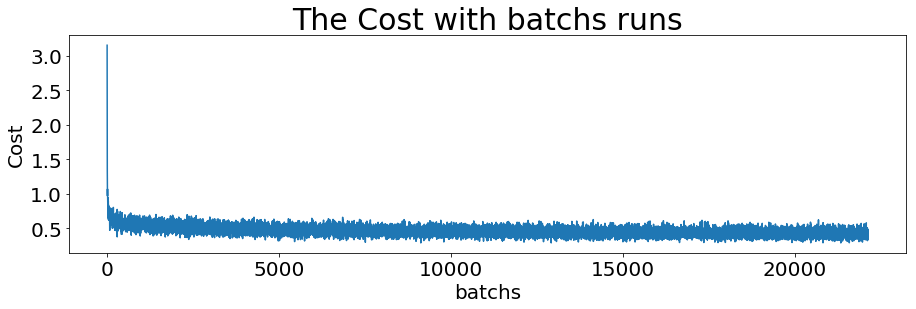

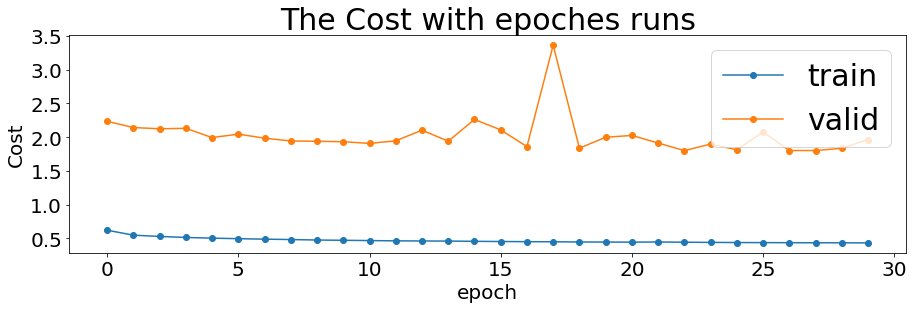

In [16]:

import matplotlib.pyplot as plt
import matplotlib
#绘制训练集在batch下的损失变化
plt.title('The Cost with batchs runs',fontsize=30)
plt.xlabel('batchs',fontsize=20)
plt.ylabel('Cost',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(history.train_losses_per_batch)
plt.gcf().set_size_inches(15,4)
plt.show()
#绘制训练集与验证集在epoch下的损失比较
plt.title('The Cost with epoches runs',fontsize=30)
plt.xlabel('epoch',fontsize=20)
plt.ylabel('Cost',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(history.train_losses_per_epoch, '-o', label='train')
plt.plot(history.valid_losses_per_epoch, '-o', label='valid')
plt.legend(fontsize=30,loc='upper right')
plt.gcf().set_size_inches(15,4)
plt.show()

In [17]:
#选取验证集准确率最高的模型
model = keras.models.load_model('./UNSW-NB15_model.h5') 
model.compile(optimizer =tf.train.AdamOptimizer(learning_rate=learning_rate),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)
#测试集的正确率
def use_evaluate_test():
    test_loss,test_acc = model.evaluate(df_test_X,df_test_y)
    print('Test accuracy:', test_acc)
    return 
use_evaluate_test()

47215/47215 [==============================] - 4s 82us/sample - loss: 0.4502 - acc: 0.8085
Test accuracy: 0.8084931


In [19]:
labelList = [
    "Normal", "Fuzzers", "Analysis", "Backdoor", "DoS", "Exploits", 
    "Generic", "Reconnaissance", "Shellcode", "Worms"
]

In [20]:
predictions = model.predict(df_test_X)
print(classification_report(df_test_y, np.argmax(predictions, axis=1) , target_names=labelList))

                precision    recall  f1-score   support

        Normal       0.89      0.94      0.92     18000
       Fuzzers       0.70      0.50      0.58      4800
      Analysis       1.00      0.04      0.07       480
      Backdoor       0.67      0.06      0.11       400
           DoS       0.38      0.42      0.40      3200
      Exploits       0.66      0.74      0.70      8000
       Generic       1.00      0.97      0.99     10000
Reconnaissance       0.78      0.77      0.78      2000
     Shellcode       0.57      0.60      0.59       300
         Worms       0.50      0.11      0.19        35

     micro avg       0.81      0.81      0.81     47215
     macro avg       0.71      0.52      0.53     47215
  weighted avg       0.81      0.81      0.80     47215



In [21]:
from sklearn.ensemble import RandomForestClassifier
score = 0
for i in range(20):
    rfc = RandomForestClassifier()
    rfc.fit(df_train_X, df_train_y)
    y_pred = rfc.predict(df_test_X)
    result = rfc.score(df_test_X, df_test_y)
    if(score < result):
        score = result
        print(score)
        print(classification_report(df_test_y, y_pred, target_names=labelList))
        
#测试集的正确率
#测试集的各个参数

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8164142751244308
                precision    recall  f1-score   support

        Normal       0.91      0.94      0.93     18000
       Fuzzers       0.67      0.60      0.63      4800
      Analysis       0.84      0.11      0.19       480
      Backdoor       0.67      0.09      0.15       400
           DoS       0.37      0.31      0.34      3200
      Exploits       0.64      0.78      0.70      8000
       Generic       1.00      0.98      0.99     10000
Reconnaissance       0.88      0.74      0.81      2000
     Shellcode       0.66      0.54      0.59       300
         Worms       0.33      0.09      0.14        35

     micro avg       0.82      0.82      0.82     47215
     macro avg       0.70      0.52      0.55     47215
  weighted avg       0.82      0.82      0.81     47215



/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8164566345441068
                precision    recall  f1-score   support

        Normal       0.91      0.94      0.92     18000
       Fuzzers       0.67      0.59      0.63      4800
      Analysis       0.91      0.10      0.19       480
      Backdoor       0.61      0.09      0.16       400
           DoS       0.37      0.32      0.34      3200
      Exploits       0.64      0.79      0.71      8000
       Generic       1.00      0.97      0.99     10000
Reconnaissance       0.91      0.74      0.82      2000
     Shellcode       0.65      0.59      0.62       300
         Worms       0.30      0.09      0.13        35

     micro avg       0.82      0.82      0.82     47215
     macro avg       0.70      0.52      0.55     47215
  weighted avg       0.82      0.82      0.81     47215



/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8172191040982738
                precision    recall  f1-score   support

        Normal       0.91      0.94      0.93     18000
       Fuzzers       0.67      0.60      0.63      4800
      Analysis       0.86      0.10      0.18       480
      Backdoor       0.54      0.10      0.16       400
           DoS       0.36      0.31      0.33      3200
      Exploits       0.64      0.78      0.71      8000
       Generic       1.00      0.98      0.99     10000
Reconnaissance       0.91      0.75      0.82      2000
     Shellcode       0.63      0.58      0.60       300
         Worms       0.60      0.26      0.36        35

     micro avg       0.82      0.82      0.82     47215
     macro avg       0.71      0.54      0.57     47215
  weighted avg       0.82      0.82      0.81     47215



/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8172614635179498
                precision    recall  f1-score   support

        Normal       0.91      0.94      0.93     18000
       Fuzzers       0.67      0.60      0.63      4800
      Analysis       0.88      0.10      0.17       480
      Backdoor       0.70      0.09      0.16       400
           DoS       0.37      0.30      0.34      3200
      Exploits       0.64      0.79      0.71      8000
       Generic       1.00      0.98      0.99     10000
Reconnaissance       0.90      0.74      0.82      2000
     Shellcode       0.63      0.56      0.59       300
         Worms       0.43      0.09      0.14        35

     micro avg       0.82      0.82      0.82     47215
     macro avg       0.71      0.52      0.55     47215
  weighted avg       0.82      0.82      0.81     47215



/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

0.8174097214868157
                precision    recall  f1-score   support

        Normal       0.91      0.94      0.93     18000
       Fuzzers       0.67      0.60      0.64      4800
      Analysis       0.75      0.10      0.18       480
      Backdoor       0.62      0.10      0.17       400
           DoS       0.36      0.30      0.33      3200
      Exploits       0.64      0.79      0.71      8000
       Generic       1.00      0.97      0.99     10000
Reconnaissance       0.91      0.74      0.82      2000
     Shellcode       0.64      0.57      0.61       300
         Worms       0.50      0.14      0.22        35

     micro avg       0.82      0.82      0.82     47215
     macro avg       0.70      0.53      0.56     47215
  weighted avg       0.82      0.82      0.81     47215



/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
